Inventory Management (DQN Agent)
<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">مدیریت موجودی (عامل DQN)

<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">در این پروژه، ما سعی کردیم یک سیستم انبار را شبیه‌سازی کنیم و با استفاده از یادگیری تقویتی (Reinforcement Learning)، یک عامل هوشمند (Agent) طراحی کنیم که تصمیم بگیرد چه زمانی و چقدر سفارش دهد تا هزینه‌های کلی انبار (مثل نگهداری و کمبود) کاهش یابد.

<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;"
>
بخش اول :شبیه‌سازی مدیریت موجودی کالا در یک انبار که در آن تصمیم گرفته می‌شود چه مقدار سفارش داده شود.

<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">1. محیط شبیه‌سازی (InventoryEnv):

    یک انبار داریم که موجودی محدود دارد.

    در هر روز (یا گام زمانی)، ممکن است تقاضا از طرف مشتری بیاید.

    عامل باید تصمیم بگیرد که چقدر کالا سفارش دهد.

    سفارش باعث افزایش موجودی می‌شود.

    اگر تقاضا بیشتر از موجودی باشد، کمبود رخ می‌دهد و جریمه دارد.

    اگر موجودی زیاد بماند، هزینه نگهداری دارد.

    همچنین هر سفارش هزینه‌ای دارد.

In [1]:
import gym
from gym import spaces
import numpy as np
from gym.utils import seeding   

class InventoryEnv(gym.Env):
    def __init__(self):
        super(InventoryEnv, self).__init__()
        
        self.max_inventory = 100
        self.max_order = 50
        self.max_demand = 20
        self.holding_cost = 1
        self.stockout_cost = 10
        self.order_cost = 2
        self.seed()

        self.action_space = spaces.Discrete(self.max_order + 1)
        self.observation_space = spaces.Box(low=0, high=self.max_inventory, shape=(1,), dtype=np.int32)

        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.inventory_level = np.random.randint(10, 30)
        return np.array([self.inventory_level], dtype=np.int32)

    def step(self, action):
        demand = np.random.randint(0, self.max_demand)
        order_quantity = action
        received = order_quantity
        self.inventory_level += received
        sold = min(demand, self.inventory_level)
        self.inventory_level -= sold

        holding_cost = self.holding_cost * self.inventory_level
        stockout = max(demand - sold, 0)
        stockout_cost = self.stockout_cost * stockout
        order_cost = self.order_cost * order_quantity

        reward = - (holding_cost + stockout_cost + order_cost)
        done = False

        return np.array([self.inventory_level], dtype=np.int32), reward, done, {}

    def render(self, mode='human'):
        print(f"Inventory Level: {self.inventory_level}")


<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">این محیط شبیه‌سازی مدیریت موجودی است که در آن عامل باید تصمیم بگیرد چه مقدار سفارش دهد تا هزینه‌ها را کاهش دهد. هزینه‌ها شامل هزینه نگهداری کالا، هزینه کمبود کالا و هزینه سفارش هستند. محیط به صورت مرحله به مرحله پیش می‌رود و هر بار وضعیت موجودی و هزینه‌ها به‌روزرسانی می‌شوند.




<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">
    بخش دوم :
در این بخش، ما یک مدل یادگیری تقویتی ساخته‌ایم که با استفاده از شبکه عصبی عمیق، بهترین تصمیم‌ها را برای سفارش کالا در محیط موجودی می‌گیرد
2.عامل یادگیرنده (DQNAgent):


    از الگوریتم DQN (Deep Q-Network) استفاده کردیم.

    عامل با محیط تعامل می‌کند و به مرور یاد می‌گیرد بهترین تصمیم را در موقعیت‌های مختلف بگیرد.

    عامل از شبکه عصبی برای پیش‌بینی بهترین اقدام (عمل) استفاده می‌کند.

    تجربه‌های گذشته در یک حافظه ذخیره می‌شود تا یادگیری پایدار باشد.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  
        self.action_size = action_size  
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    
        self.epsilon = 1.0   
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        
    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0]) 

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">در این بخش، مدل ما یک شبکه عصبی عمیق دارد که با الگوریتم. این شبکه با گرفتن وضعیت فعلی (موجودی انبار) بهترین اقدام (مقدار سفارش) را پیش‌بینی می‌کند. در ابتدا مدل بیشتر اکتشاف می‌کند تا تجربه کسب کند، سپس به تدریج یاد می‌گیرد که بهترین تصمیم‌ها را بگیرد. داده‌های تجربه‌ شده در حافظه ذخیره می‌شود و با نمونه‌گیری از آن‌ها، شبکه به‌روزرسانی می‌شود.

<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">3. آموزش عامل:

    در ۵۰ اپیزود، مدل بارها محیط را تجربه می‌کند.

    با هر تجربه، یاد می‌گیرد که کدام تصمیم‌ها باعث کاهش هزینه‌ها می‌شود.

    به مرور، مقدار "اکتشاف" (رفتار تصادفی) کاهش می‌یابد و مدل تصمیم‌های بهتری می‌گیرد.



In [3]:
env = InventoryEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

EPISODES = 50
batch_size = 32

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    total_reward = 0

    for time in range(50):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    print(f"Episode {e+1}/{EPISODES}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")


c:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/50, Total Reward: -25273.00, Epsilon: 0.99
Episode 2/50, Total Reward: -23279.00, Epsilon: 0.99
Episode 3/50, Total Reward: -27212.00, Epsilon: 0.99
Episode 4/50, Total Reward: -25392.00, Epsilon: 0.98
Episode 5/50, Total Reward: -28855.00, Epsilon: 0.98
Episode 6/50, Total Reward: -27693.00, Epsilon: 0.97
Episode 7/50, Total Reward: -25017.00, Epsilon: 0.97
Episode 8/50, Total Reward: -23179.00, Epsilon: 0.96
Episode 9/50, Total Reward: -25097.00, Epsilon: 0.96
Episode 10/50, Total Reward: -23157.00, Epsilon: 0.95
Episode 11/50, Total Reward: -25811.00, Epsilon: 0.95
Episode 12/50, Total Reward: -19975.00, Epsilon: 0.94
Episode 13/50, Total Reward: -20662.00, Epsilon: 0.94
Episode 14/50, Total Reward: -17408.00, Epsilon: 0.93
Episode 15/50, Total Reward: -20942.00, Epsilon: 0.93
Episode 16/50, Total Reward: -19138.00, Epsilon: 0.92
Episode 17/50, Total Reward: -26161.00, Epsilon: 0.92
Episode 18/50, Total Reward: -21354.00, Epsilon: 0.91
Episode 19/50, Total Reward: -25366.0

<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;">
پس از آموزش، ما عملکرد عامل را بر اساس سه معیار تحلیل کردیم:
 1. پاداش تجمعی (Cumulative Reward):

    هرچه این مقدار بالاتر باشد، یعنی عامل توانسته هزینه‌های کمتر و سود بهتری کسب کند.

    نمودار نشان می‌دهد که عامل با گذر زمان عملکردش بهتر شده.

 2. پایداری موجودی (Inventory Stability):

    با بررسی واریانس سطح موجودی در هر اپیزود، می‌بینیم که با گذر زمان، نوسانات کاهش یافته و عامل موجودی را پایدارتر مدیریت کرده.

 3. کاهش کمبود کالا (Stockout):

    کمبود به این معنی است که کالا به‌اندازه کافی در انبار نبوده تا نیاز مشتری را پاسخ دهد.

    عامل به مرور یاد گرفته که چطور سفارش بدهد تا کمبود رخ ندهد و هزینه‌ کمبود کاهش یابد.

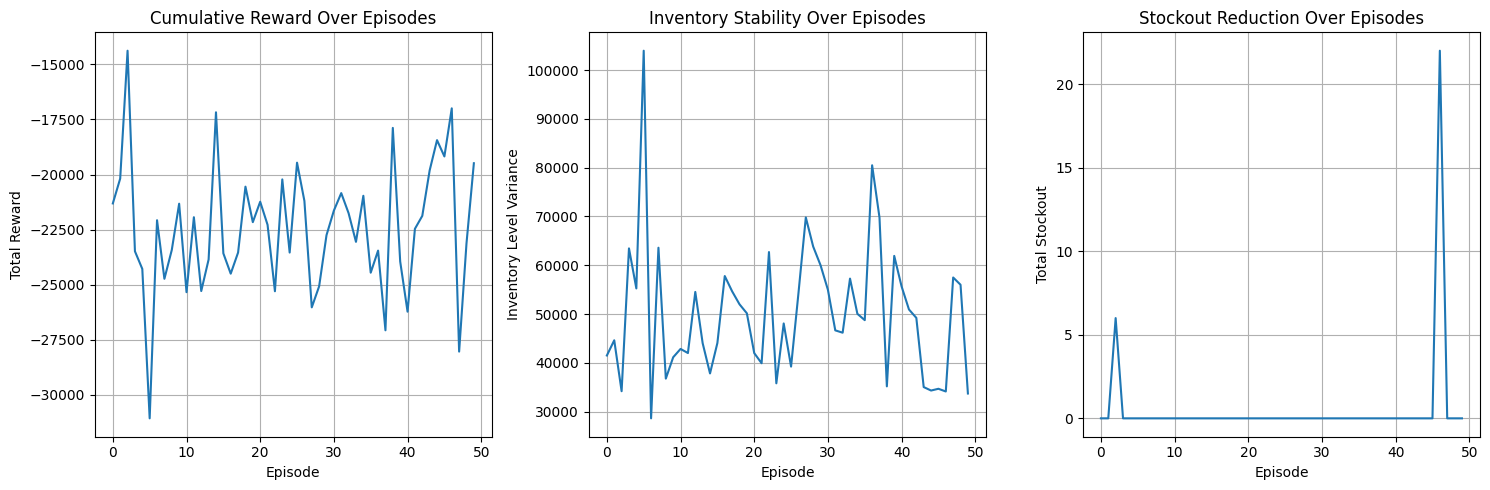

In [4]:
import matplotlib.pyplot as plt

inventory_levels_per_episode = []
stockouts_per_episode = []
rewards_per_episode = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    inventory_levels = []
    total_stockout = 0

    for time in range(50):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        total_reward += reward
        
        # ذخیره موجودی برای محاسبه پایداری
        inventory_levels.append(next_state[0][0])
        
        stockout_cost = ( -reward - env.holding_cost * next_state[0][0] - env.order_cost * action ) / env.stockout_cost
        stockout = max(stockout_cost, 0)
        total_stockout += stockout

        if done:
            break

    inventory_levels_per_episode.append(np.var(inventory_levels))
    stockouts_per_episode.append(total_stockout)
    rewards_per_episode.append(total_reward)

# رسم نمودار پاداش تجمعی
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(range(EPISODES), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Cumulative Reward Over Episodes')
plt.grid(True)

# رسم نمودار پایداری موجودی (واریانس موجودی)
plt.subplot(1,3,2)
plt.plot(range(EPISODES), inventory_levels_per_episode)
plt.xlabel('Episode')
plt.ylabel('Inventory Level Variance')
plt.title('Inventory Stability Over Episodes')
plt.grid(True)

# رسم نمودار کمبود کالا
plt.subplot(1,3,3)
plt.plot(range(EPISODES), stockouts_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Stockout')
plt.title('Stockout Reduction Over Episodes')
plt.grid(True)

plt.tight_layout()
plt.show()



<div dir="rtl" style="text-align: right; font-family: Tahoma, Arial, sans-serif;"> از آموزش مدل ما عملکرد او را در محیط آزمایش می‌کنیم و سه معیار اصلی را تحلیل می‌کنیم:

    1.پاداش تجمعی (که کاهش هزینه‌ها را نشان می‌دهد)
    2.پایداری موجودی (کاهش نوسانات موجودی انبار)
    3.کمبود کالا (کاهش تعداد دفعات کمبود کالا)
    این معیارها به ما نشان می‌دهند که عامل در طول زمان بهتر عمل کرده و هزینه‌ها و مشکلات انبار را کاهش داده است.